In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read Files

In [2]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [3]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [4]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [5]:
X_train_split_0, X_val, y_train_split_0, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split_0:", X_train_split_0.shape)
print("X_val:", X_val.shape)
print("y_train_split_0:", y_train_split_0.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split_0: (78197, 33)
X_val: (33514, 33)
y_train_split_0: (78197,)
y_val: (33514,)


In [6]:
Y1= pd.concat([X_train_split_0, y_train_split_0], axis=1)

In [7]:
Y1

,EverAtLeast1DPD_3mos,EverAtLeast15DPD_3mos,EverAtLeast31DPD_3mos,EverAtLeast61DPD_3mos,EverAtLeast1DPD_6mos,EverAtLeast15DPD_6mos,EverAtLeast31DPD_6mos,EverAtLeast61DPD_6mos,EverAtLeast1DPD_9mos,EverAtLeast15DPD_9mos,...,Missed_past6mos,Partial_past6mos,Full_past6mos,Missed_past9mos,Partial_past9mos,Full_past9mos,Missed_past12mos,Partial_past12mos,Full_past12mos,DEFAULT_TAGGING
11757,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
39534,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
9963,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
72838,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
40217,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,2,0,10,0
24028,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
36067,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,2,0,10,0
24985,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,3,0,9,0


In [8]:
# Define X1 (features) and y1 (target)
X_1 = Y1.drop(columns=["DEFAULT_TAGGING"])  
Y_1 = Y1["DEFAULT_TAGGING"].astype(int)  # Convert target to integer Series

In [9]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# import numpy as np
# import pandas as pd
from collections import Counter

# Define feature groups
binary_features = ['EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos',
                   'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos',
                   'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos',
                   'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos']

ordinal_features = ['WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos']

continuous_features = ['RemainingLoanRatio_12mos']

count_features = ['Missed_past3mos', 'Partial_past3mos', 'Full_past3mos',
                  'Missed_past6mos', 'Partial_past6mos', 'Full_past6mos',
                  'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos',
                  'Missed_past12mos', 'Partial_past12mos', 'Full_past12mos']

# Get categorical feature indices for SMOTE-NC  
categorical_feature_indices = [X_1.columns.get_loc(col) for col in binary_features + ordinal_features]

# Apply undersampling and SMOTENC after

under = RandomUnderSampler(random_state=42, sampling_strategy=.5)

over = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.80)

steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)

X1_resampled, Y1_resampled  = pipeline.fit_resample(X_1, Y_1)

# Convert back to DataFrame
x1_resampled = pd.DataFrame(X1_resampled, columns=X_1.columns)
y1_resampled = pd.Series(Y1_resampled, name="DEFAULT_TAGGING")

# Post-processing: Round categorical & count features
x1_resampled[binary_features] = x1_resampled[binary_features].round().astype(int)
x1_resampled[ordinal_features] = x1_resampled[ordinal_features].round().astype(int)
x1_resampled[count_features] = x1_resampled[count_features].round().astype(int)

# Print class distribution
print("Before SMOTE:", Counter(Y_1))
print("After SMOTE:", Counter(y1_resampled))

Before SMOTE: Counter({0: 77699, 1: 498})
After SMOTE: Counter({0: 996, 1: 796})


In [10]:
Y1_resampled = pd.concat([x1_resampled, y1_resampled], axis=1)

# Check if rows are still aligned properly
print(Y1_resampled.tail())  # Preview first few rows

      EverAtLeast1DPD_3mos  EverAtLeast15DPD_3mos  EverAtLeast31DPD_3mos  \
1787                     1                      1                      1   
1788                     1                      1                      1   
1789                     1                      1                      1   
1790                     0                      0                      0   
1791                     1                      1                      1   

      EverAtLeast61DPD_3mos  EverAtLeast1DPD_6mos  EverAtLeast15DPD_6mos  \
1787                      1                     1                      1   
1788                      1                     1                      1   
1789                      1                     1                      1   
1790                      0                     1                      0   
1791                      1                     1                      1   

      EverAtLeast31DPD_6mos  EverAtLeast61DPD_6mos  EverAtLeast1DPD_9mos  \
1787      

In [11]:
xvars = [
    'EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos', 'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 'Partial_past3mos', 'Full_past3mos', 'Missed_past6mos', 'Partial_past6mos', 
    'Full_past6mos', 'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 'Full_past12mos'
]
    
yvar = 'DEFAULT_TAGGING'  # Target variable for y1

# Prepare training data (y1)
X_train_split = Y1_resampled[xvars]
y_train_split = Y1_resampled[yvar]

#### Option 2 Grid Search 

In [12]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return thresholds[optimal_idx]  # Return scalar instead of list
#change param_grid based on your chosen range of value
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):

    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }














    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Find optimal probability threshold
        optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:, 1])

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results


In [13]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31105
False Positives (FP): 2196
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.3768
 → Recall: 0.9577, Specificity: 0.9341

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31472
False Positives (FP): 1829
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.3957
 → Recall: 0.9577, Specificity: 0.9451

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30958
False Positives (FP): 2343
False Negatives (FN): 6
True Positives (TP): 207
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3310
 → Recall: 0.9718, Specificity: 0.9296

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31626
False Positives (FP): 1675
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4285
 → Recall: 0.9531, Specificity: 0.9497

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31367
False Positives (FP): 1934
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3811
 → Recall: 0.9671, Specificity: 0.9419

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31245
False Positives (FP): 2056
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.3589
 → Recall: 0.9577, Specificity: 0.9383

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31970
False Positives (FP): 1331
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4809
 → Recall: 0.9437, Specificity: 0.9600

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32187
False Positives (FP): 1114
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.5852
 → Recall: 0.9296, Specificity: 0.9665

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31428
False Positives (FP): 1873
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.4102
 → Recall: 0.9577, Specificity: 0.9438

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31838
False Positives (FP): 1463
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4477
 → Recall: 0.9484, Specificity: 0.9561

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32083
False Positives (FP): 1218
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.5695
 → Recall: 0.9343, Specificity: 0.9634

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31947
False Positives (FP): 1354
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.5552
 → Recall: 0.9343, Specificity: 0.9593

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30920
False Positives (FP): 2381
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3095
 → Recall: 0.9671, Specificity: 0.9285

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31987
False Positives (FP): 1314
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.5756
 → Recall: 0.9390, Specificity: 0.9605

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32071
False Positives (FP): 1230
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.6297
 → Recall: 0.9343, Specificity: 0.9631

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31764
False Positives (FP): 1537
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.4934
 → Recall: 0.9390, Specificity: 0.9538

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31540
False Positives (FP): 1761
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.4102
 → Recall: 0.9531, Specificity: 0.9471

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31813
False Positives (FP): 1488
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.4892
 → Recall: 0.9390, Specificity: 0.9553

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31893
False Positives (FP): 1408
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.5703
 → Recall: 0.9296, Specificity: 0.9577

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31723
False Positives (FP): 1578
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.4726
 → Recall: 0.9390, Specificity: 0.9526

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31258
False Positives (FP): 2043
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.4086
 → Recall: 0.9531, Specificity: 0.9387

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31708
False Positives (FP): 1593
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4275
 → Recall: 0.9484, Specificity: 0.9522

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31465
False Positives (FP): 1836
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3968
 → Recall: 0.9577, Specificity: 0.9449

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31732
False Positives (FP): 1569
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4499
 → Recall: 0.9437, Specificity: 0.9529

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31155
False Positives (FP): 2146
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3524
 → Recall: 0.9671, Specificity: 0.9356

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31442
False Positives (FP): 1859
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.3987
 → Recall: 0.9577, Specificity: 0.9442

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31356
False Positives (FP): 1945
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.3176
 → Recall: 0.9531, Specificity: 0.9416

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31716
False Positives (FP): 1585
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.4467
 → Recall: 0.9390, Specificity: 0.9524

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31186
False Positives (FP): 2115
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.3643
 → Recall: 0.9671, Specificity: 0.9365

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31699
False Positives (FP): 1602
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4189
 → Recall: 0.9531, Specificity: 0.9519

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31639
False Positives (FP): 1662
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.3694
 → Recall: 0.9437, Specificity: 0.9501

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31357
False Positives (FP): 1944
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.2609
 → Recall: 0.9437, Specificity: 0.9416

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31466
False Positives (FP): 1835
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3970
 → Recall: 0.9531, Specificity: 0.9449

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31860
False Positives (FP): 1441
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.4865
 → Recall: 0.9343, Specificity: 0.9567

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31618
False Positives (FP): 1683
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.4025
 → Recall: 0.9437, Specificity: 0.9495

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31414
False Positives (FP): 1887
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.2643
 → Recall: 0.9437, Specificity: 0.9433

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31904
False Positives (FP): 1397
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.5022
 → Recall: 0.9437, Specificity: 0.9580

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31509
False Positives (FP): 1792
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.3410
 → Recall: 0.9437, Specificity: 0.9462

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31450
False Positives (FP): 1851
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.3101
 → Recall: 0.9484, Specificity: 0.9444

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 30989
False Positives (FP): 2312
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.1738


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31258
False Positives (FP): 2043
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.4086
 → Recall: 0.9531, Specificity: 0.9387

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31708
False Positives (FP): 1593
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4274
 → Recall: 0.9484, Specificity: 0.9522

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31528
False Positives (FP): 1773
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3985
 → Recall: 0.9577, Specificity: 0.9468

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31563
False Positives (FP): 1738
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4026
 → Recall: 0.9484, Specificity: 0.9478

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31156
False Positives (FP): 2145
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3524
 → Recall: 0.9671, Specificity: 0.9356

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31561
False Positives (FP): 1740
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=60, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.4226
 → Recall: 0.9531, Specificity: 0.9477

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31711
False Positives (FP): 1590
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4269
 → Recall: 0.9390, Specificity: 0.9523

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31466
False Positives (FP): 1835
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.3391
 → Recall: 0.9484, Specificity: 0.9449

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start train

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31187
False Positives (FP): 2114
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.3643
 → Recall: 0.9671, Specificity: 0.9365

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31524
False Positives (FP): 1777
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.3789
 → Recall: 0.9531, Specificity: 0.9466

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31555
False Positives (FP): 1746
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.3817
 → Recall: 0.9484, Specificity: 0.9476

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30933
False Positives (FP): 2368
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3121
 → Recall: 0.9671, Specificity: 0.9289

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31712
False Positives (FP): 1589
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.4417
 → Recall: 0.9390, Specificity: 0.9523

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31426
False Positives (FP): 1875
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.2849
 → Recall: 0.9390, Specificity: 0.9437

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the trai

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31178
False Positives (FP): 2123
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.3179
 → Recall: 0.9577, Specificity: 0.9362

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31615
False Positives (FP): 1686
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.4409
 → Recall: 0.9390, Specificity: 0.9494

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31554
False Positives (FP): 1747
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=60, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.4190
 → Recall: 0.9437, Specificity: 0.9475

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31258
False Positives (FP): 2043
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.4086
 → Recall: 0.9531, Specificity: 0.9387

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31708
False Positives (FP): 1593
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4274
 → Recall: 0.9484, Specificity: 0.9522

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31528
False Positives (FP): 1773
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3985
 → Recall: 0.9577, Specificity: 0.9468

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31563
False Positives (FP): 1738
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4026
 → Recall: 0.9484, Specificity: 0.9478

[LightGBM] [Warning] Unknown parame

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31156
False Positives (FP): 2145
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3524
 → Recall: 0.9671, Specificity: 0.9356

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31561
False Positives (FP): 1740
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=80, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.4226
 → Recall: 0.9531, Specificity: 0.9477

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31210
False Positives (FP): 2091
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.2928
 → Recall: 0.9577, Specificity: 0.9372

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[Li

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31187
False Positives (FP): 2114
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.3643
 → Recall: 0.9671, Specificity: 0.9365

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31739
False Positives (FP): 1562
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4247
 → Recall: 0.9484, Specificity: 0.9531

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30933
False Positives (FP): 2368
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3121
 → Recall: 0.9671, Specificity: 0.9289

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31712
False Positives (FP): 1589
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.4417
 → Recall: 0.9390, Specificity: 0.9523

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31544
False Positives (FP): 1757
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=80, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.3490
 → Recall: 0.9390, Specificity: 0.9472

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31178
False Positives (FP): 2123
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.3181
 → Recall: 0.9577, Specificity: 0.9362

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31535
False Positives (FP): 1766
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.3598
 → Recall: 0.9437, Specificity: 0.9470

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31452
False Positives (FP): 1849
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=80, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.3017
 → Recall: 0.9437, Specificity: 0.9445

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31258
False Positives (FP): 2043
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.4086
 → Recall: 0.9531, Specificity: 0.9387

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31708
False Positives (FP): 1593
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4274
 → Recall: 0.9484, Specificity: 0.9522

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31528
False Positives (FP): 1773
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=100, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3985
 → Recall: 0.9577, Specificity: 0.9468

[LightGBM] [Warning] Unknown parame

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31156
False Positives (FP): 2145
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3524
 → Recall: 0.9671, Specificity: 0.9356

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31561
False Positives (FP): 1740
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=100, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.4226
 → Recall: 0.9531, Specificity: 0.9477

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31187
False Positives (FP): 2114
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.3643
 → Recall: 0.9671, Specificity: 0.9365

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31739
False Positives (FP): 1562
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4247
 → Recall: 0.9484, Specificity: 0.9531

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30933
False Positives (FP): 2368
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3121
 → Recall: 0.9671, Specificity: 0.9289

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31712
False Positives (FP): 1589
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.4417
 → Recall: 0.9390, Specificity: 0.9523

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31543
False Positives (FP): 1758
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=100, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.3490
 → Recall: 0.9390, Specificity: 0.9472

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31178
False Positives (FP): 2123
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.3181
 → Recall: 0.9577, Specificity: 0.9362

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31535
False Positives (FP): 1766
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=100, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.3598
 → Recall: 0.9437, Specificity: 0.9470

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## LGBM MODEL

In [21]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate= 0.03,
    num_iterations=150,
    num_leaves=20,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)

#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 796, number of negative: 996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444196 -> initscore=-0.224148
[LightGBM] [Info] Start training from score -0.224148
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Model Training Complete


## Option 1: Optimal Threshold using Precision-Recall Curve

In [15]:
# # Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
# precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# # Compute F1 score for each threshold
# f1_scores = 2 * (precision * recall) / (precision + recall)

# # Find the threshold that maximizes F1 score
# optimal_threshold = thresholds[np.argmax(f1_scores)]

# print("Optimal threshold for maximum F1 score:", optimal_threshold)

## Option 2: Optimal Threshold using ROC Curve

In [22]:
def Find_Optimal_Cutoff(target, predicted):
    """
    Find the optimal probability cutoff point for a classification model using Youden’s J statistic.

    Parameters
    ----------
    target : true class labels
    predicted : predicted probabilities for the positive class

    Returns
    -------
    list : optimal threshold value(s)
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return [thresholds[optimal_idx]]


# Find optimal probability threshold
optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:,1])
print(optimal_threshold)

[0.33101694366207945]


## Option 3: Optimal Threshold using Matthews Correlation Coefficient

## Apply Optimal Threshold

In [23]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [24]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 30958
False Positives (FP): 2343
False Negatives (FN): 6
True Positives (TP): 207
[[30958  2343]
 [    6   207]]
Accuracy: 0.9299
Precision: 0.0812
Recall: 0.9718
F1 Score: 0.1498
AUC: 0.9842
Specificity: 0.9296


## SHAP Plots

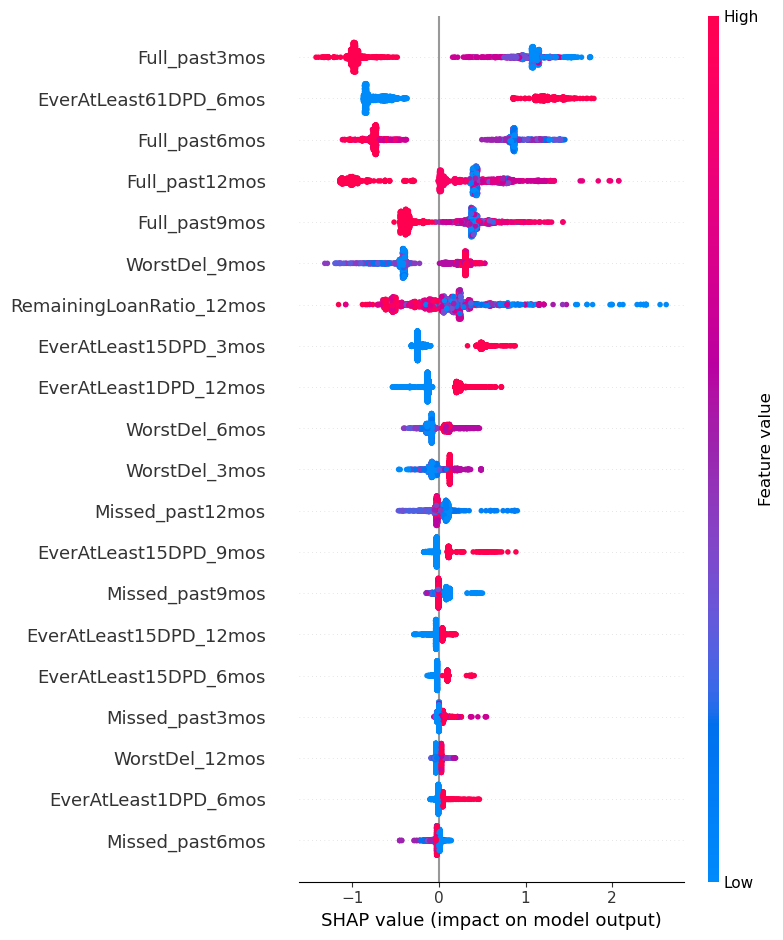

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

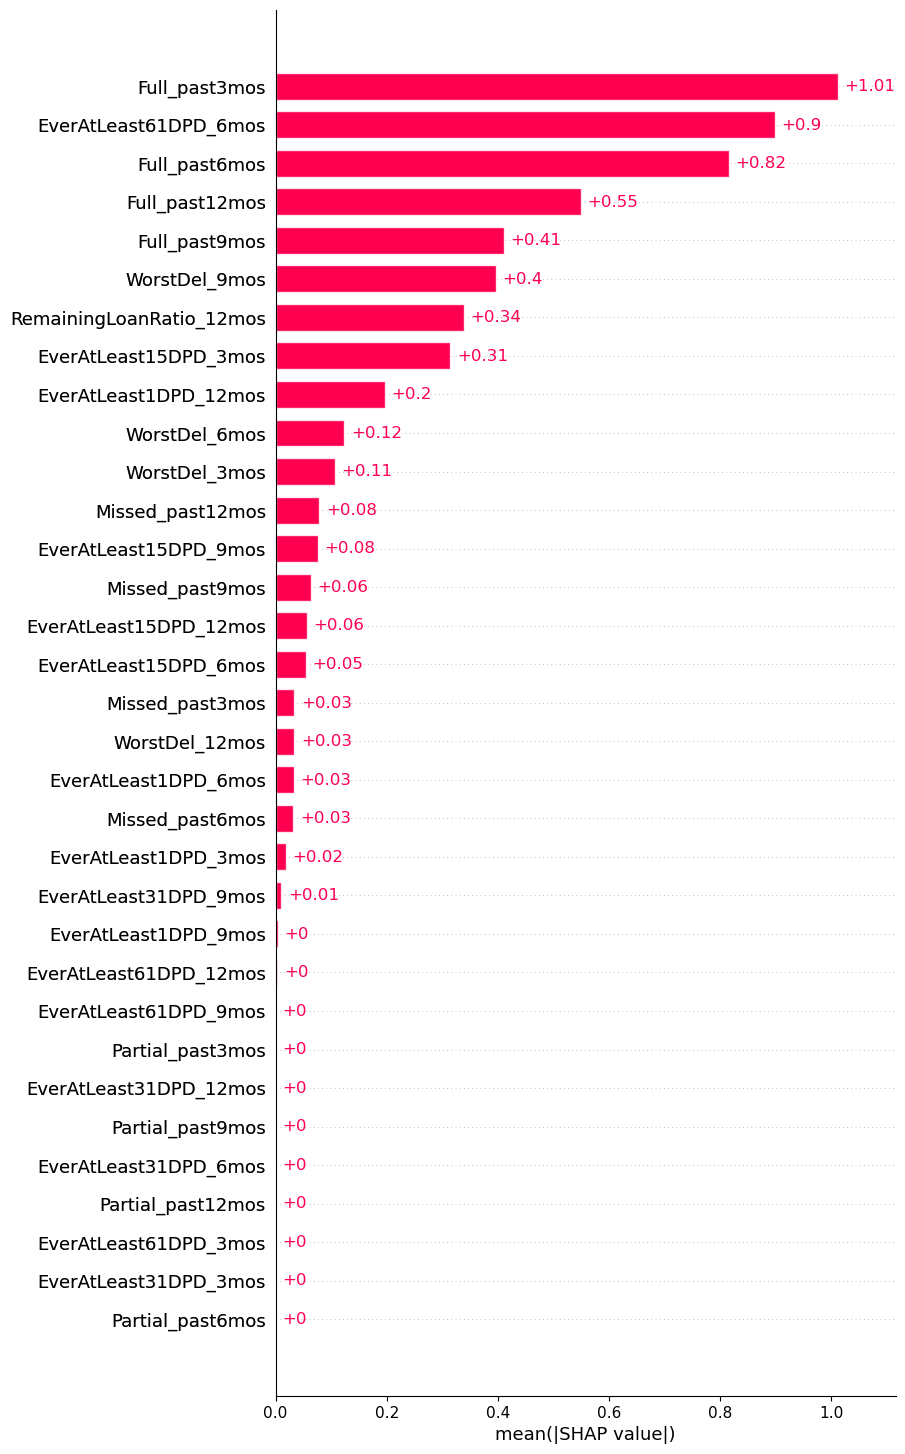

In [20]:
shap.plots.bar(shap_values, max_display=50)